In [47]:
import numpy as np
from scipy import integrate

import matplotlib.pyplot as plt
%matplotlib notebook

import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format

from IPython.display import display
from sklearn import model_selection
from sklearn.datasets import load_digits

In [3]:
# load digits data set
digits = load_digits()

feature = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

In [4]:
# split into train and test data
X_all = feature
y_all = target
X_train, X_test, y_train , y_test = model_selection.train_test_split(
                                    digits.data,
                                    digits.target,
                                    test_size = 0.4,
                                    random_state = 0)

# 2 Precision-Recall Curves

## 2.1 Euclidean Distance

#### Alternative vectorized approach - COPY from ex01b

Alternatively, the Euclidean distance between vectors $\textbf{a}, \textbf{b} \in \mathbb{R}^N$ can be transformed as follows:

\begin{align}
\text{dist}(\textbf{a}, \textbf{b})
&= \sqrt{ (a_1 - b_1)^2 + (a_2 - b_2)^2 + \ldots } \\
&= \sqrt{ (a_1^2 + a_2^2 + \ldots) + (b_1^2 + b_2^2 + \ldots) - (2 a_1 b_1 + 2 a_2 b_2 + \ldots) } \\
&= \sqrt{ \sum_i a_i^2 + \sum_i b_i^2 - 2 \cdot \textbf{a}^\top \cdot \textbf{b} } \\
\end{align}

This computation can also be performed for many vectors at once by operating on matrices $\textbf{A} \in \mathbb{R}^{I \times N}$ and $\textbf{B} \in \mathbb{R}^{J \times N}$, which contain the $\textbf{a}$s and $\textbf{b}$s as rows. This method turns out to be considerably faster, since the largest constructed matrix is of size $I \times J$, as opposed to the $I \times J \times N$-matrix we constructed in the previous vectorized method.

In [35]:
def dist_vec_alternative(training, test):
    AB = np.dot(test, np.transpose(training)) # shape is (n_test, n_train)
    AA = np.sum(np.square(test), axis = 1) # shape is (n_test,)
    BB = np.sum(np.square(training), axis = 1) # shape is (n_train,)

    dist_matrix = np.sqrt(np.transpose(BB - 2 * AB) + AA) # shape is (n_train, n_test)

    return dist_matrix

#this function gives back a label matrix, where indices with closest
# distance are coming first
def similarity_ordering(feature, label):
    distance = dist_vec_alternative(feature,feature)
    
    N = np.size(label)
    ordered_labels = np.zeros((N,N))
    indizes = np.zeros((N,N))
    
    for i in range(N):
        indizes[i,:] = np.argsort(distance[i,:])
        for k in range(N):
            ordered_labels[i,k] = label[int(indizes[i,k])]
    return ordered_labels

def t_pos(feature, label):
    label_matrix = similarity_ordering(feature, label)
    N = np.size(label_matrix,0)
    tp_mi = np.zeros((N,N))
    for m in range(N):
        tp_mi[m,:] = np.sum(
            (np.subtract(label_matrix[:,:m+1],np.expand_dims(label_matrix[:,0],1)@np.expand_dims(np.ones(m+1),0)) == 0),1)                     
    tp_im = tp_mi.T
    return tp_im

# create a matrix with dim m where true and false pos are added
def positive(N):
    p_im = np.expand_dims(np.ones(N),1)@np.expand_dims(np.arange(1,N+1),0)
    return p_im


#returns the precission/recall matrix
def precision_and_recall(feature, label):
    N = np.size(label)
    
    tp = t_pos(feature, label)
    pos = positive(N)
    
    p = np.divide(tp,pos)
    r = np.divide(tp,tp[:,-1])
                
    return p, r

In [36]:
#now calculate average in different classes:
def average(feature, label, classes):    
    p,r = precision_and_recall(feature, label)
    
    N = np.size(label)
    K = np.size(classes)
    
    p_av = np.zeros((K,N))
    r_av = np.zeros((K,N))
    
    for k in classes:
        index = np.where(label==k)
        
        p_av[k,:] = (1/np.sum(np.size(index)))*np.sum(np.sum([p[i] for i in index], axis=0),axis = 0)
        r_av[k,:] = (1/np.sum(np.size(index)))*np.sum(np.sum([r[i] for i in index], axis=0),axis = 0)
        
    return p_av, r_av

In [37]:
classes = np.arange(10)
N = np.size(y_all)
m = np.arange(1,N+1)

precision = np.zeros((10,N))
recall = np.zeros((10,N))

#%timeit precision, recall = average(X_all, y_all,classes)
precision, recall = average(X_all, y_all,classes)


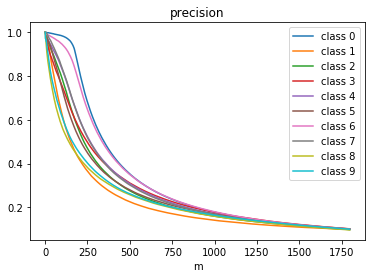

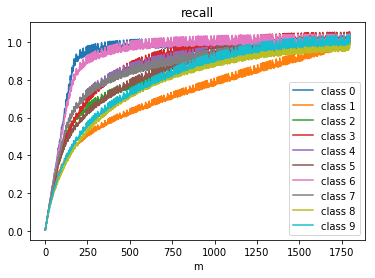

In [38]:
for k in classes:
    plt.plot(m,precision[k,:], label='class '+str(k))
plt.legend()
plt.xlabel('m')
plt.title('precision')
plt.show()

for k in classes:
    plt.plot(m,recall[k,:], label='class '+str(k))
plt.legend()
plt.xlabel('m')
plt.title('recall')
plt.show()

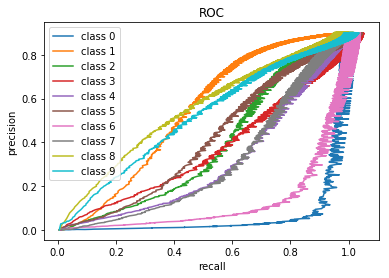

In [42]:
#plot ROC for different classes, depending on m

for k in classes:
    plt.plot(recall[k,:],(1-precision[k,:]), label='class '+str(k))
plt.legend()
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('ROC')
plt.show()

<IPython.core.display.Javascript object>


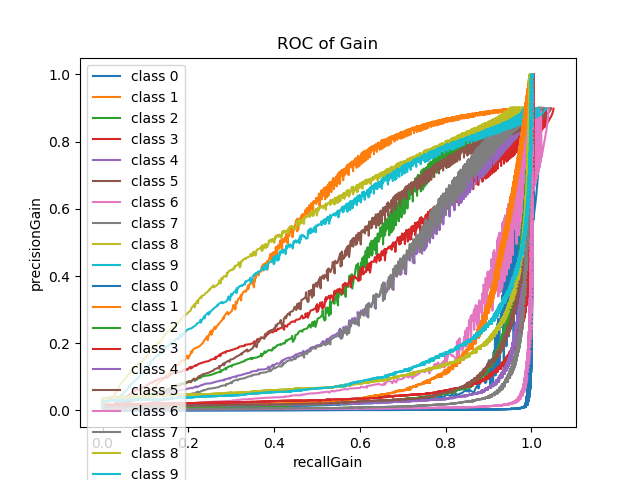

In [50]:
# Now, AUC of ROC:
auc = np.zeros(10)

for k in classes:
    ind = np.argsort(recall[k,:])
    x = recall[k,ind]
    y = 1 - precision[k,ind]
    plt.plot(x,y, label='class '+str(k))
    auc[k] = integrate.simps(x,(y-x))
plt.legend()
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('ROC - reordered to calculate AUC')
plt.show()

In [51]:
print('These are the AUC of the ROC for each class k: \n'+str(auc))

These are the AUC of the ROC for each class k: 
[ 0.31660679 -0.19092116 -0.00426688  0.17168408  0.06279335 -0.24585316
  0.23694787  0.05386418 -0.14620309 -0.14112901]


## For precision and recall gain...

In [58]:
#returns the precission/recall matrix
def precision_and_recallGain(feature, label):
    N = np.size(label)
    
    tp = t_pos(feature, label)
    pos = positive(N)
    
    Ni = tp[:,-1]
    
    p = np.divide(tp,pos)
    r = np.divide(tp,Ni)
    
    pG = np.zeros(np.shape(p))
    rG = np.zeros(np.shape(r))
    
    for i in range(N): #sorry, using loops...
        for m in range(N):
            pG[i,m] = np.maximum([0],[((N/Ni[i])-(1/p[i,m]))/((N/Ni[i])-1)])
            rG[i,m] = np.maximum([0],[((N/Ni[i])-(1/r[i,m]))/((N/Ni[i])-1)])
    return pG, rG
    
    
#now calculate average in different classes:
def averageGain(feature, label, classes):    
    p,r = precision_and_recallGain(feature, label)
    
    N = np.size(label)
    K = np.size(classes)
    
    p_av = np.zeros((K,N))
    r_av = np.zeros((K,N))
    
    for k in classes:
        index = np.where(label==k)
        
        p_av[k,:] = (1/np.sum(np.size(index)))*np.sum(np.sum([p[i] for i in index], axis=0),axis = 0)
        r_av[k,:] = (1/np.sum(np.size(index)))*np.sum(np.sum([r[i] for i in index], axis=0),axis = 0)
        
    return p_av, r_av

In [69]:
precisionGain = np.zeros((10,N))
recallGain = np.zeros((10,N))

#%timeit precision, recall = average(X_all, y_all,classes)
precisionGain, recallGain = averageGain(X_all, y_all,classes)

#plot ROC for different classes, depending on m

for k in classes:
    plt.plot(recallGain[k,:],(1-precisionGain[k,:]), label='class '+str(k))
plt.legend()
plt.ylabel('precisionGain')
plt.xlabel('recallGain')
plt.title('ROC of Gain')
plt.show()

In [68]:
# Calc AUC of ROC from Gain
aucGain = np.zeros(10)

for k in classes:
    ind = np.argsort(recallGain[k,:])
    x = recallGain[k,ind]
    x_new = x[(np.where(x == 0)[-1][-1]):]
    y = 1 - precisionGain[k,ind]
    y_new = y[np.where(x == 0)[-1][-1]:]
    plt.plot(x_new,y_new, label='class '+str(k))
    aucGain[k] = integrate.simps(x,(y-x))
plt.legend()
plt.ylabel('precision')
plt.xlabel('recall')
plt.title('ROC - reordered to calculate AUC')
plt.show()

print('These are the AUC of the ROC for each class k: \n'+str(aucGain))

These are the AUC of the ROC for each class k: 
[       nan 0.38639443 0.44105944 0.444602   0.45373848 0.44102142
        nan 0.46830867 0.39396732 0.38380249]


/home/sonja/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:326: RuntimeWarning: divide by zero encountered in true_divide
  h0divh1 = h0 / h1
/home/sonja/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:328: RuntimeWarning: divide by zero encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/sonja/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:328: RuntimeWarning: invalid value encountered in multiply
  y[slice1]*hsum*hsum/hprod +
/home/sonja/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:328: RuntimeWarning: invalid value encountered in true_divide
  y[slice1]*hsum*hsum/hprod +
/home/sonja/.local/lib/python3.6/site-packages/scipy/integrate/quadrature.py:329: RuntimeWarning: invalid value encountered in multiply
  y[slice2]*(2-h0divh1))


## A comment on the differences

Our second solution gives an error due to division by zero, we could not fix it anymore and therefor it is difficult to compare the results

But in general is the area under the curve of the precision and recall gain curve much higher.

2.2 Two Features

In [ ]:
def reduce_dim(x):
    """
    Perform a user defined dimension reduction
    input: N x 64 numpy array 
    output: N x 2 numpy array
    """
    # mean(Upper part) - mean(Lower part)
    feat1 = (np.mean(x[:, :x.shape[-1]//4], axis=-1) -
             np.mean(x[:, 3 * x.shape[-1]//4:], axis=-1))

    # mean(Upper part) * mean(Lower part)
    feat2 = (np.mean(x[:, :x.shape[-1]//4] * x[:, 3 * x.shape[-1]//4:], axis=-1))
        
    return np.array([feat1, feat2]).T



def average_both(feature, label, classes):
    feature = reduce_dim(feature)
    p_av_1, r_av1 = average(feature[:,0], label, classes)
    p_av_2, r_av2 = average(feature[:,1], label, classes)
    return p_av_1, r_av1, p_av_1, r_av1











def average_both_2(feature, label, classes):
    p_av_1, r_av1 = average(feature[:,:,0], label, classes)
    p_av_2, r_av2 = average(feature[:,:,1], label, classes)
    return  p_av_1, r_av1, p_av_1, r_av1


#Feature ideas: number of "holes", using symmetries of the numbers and try to find them by (prob.) 
#a kernel density plot and rotations, ... 